# Project 6a: 3D Line Formation
Candidate number: 


#### Header and imports

The cells below contain some code to label equations in Markdown and some recommended python imports to solve the exercises.

In [2]:
%%javascript  # Allow equation numbers
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from astropy import units
from astropy import constants
from astropy.table import QTable  # to use tables with units
from astropy.modeling.models import BlackBody  # to compute the Planck function
from astropy.visualization import quantity_support
from IPython.display import set_matplotlib_formats
from numpy import newaxis as nax  # to simplify the many uses of this

quantity_support()
set_matplotlib_formats('svg')
plt.rc('legend', frameon=False)
plt.rc('figure', figsize=(7, 7 / 1.75)) # Larger figure sizes
plt.rc('font', size=12)

from scipy.integrate import cumtrapz   # for tau integration
from scipy.ndimage import shift  # for "rotating" 3D cubes
from scipy.special import wofz   # for Voigt function

i_units = "kW m-2 sr-1 nm-1"  # More practical SI units

The function `compute_hminus_cross_section` has its origin from earlier projects and will be reused here.

In [15]:
def compute_hminus_cross_section(wavelength, temperature, electron_density):
    """
    Computes the H minus extinction cross section, both free-free and
    bound-free as per Gray (1992).
    
    Parameters
    ----------
    wavelength : astropy.units.quantity (array)
        Wavelength(s) to calculate in units of length.
    temperature: astropy.units.quantity (scalar or array)
        Gas temperature in units of K or equivalent.
    electron_density: astropy.units.quantity (scalar or array)
        Electron density in units of per cubic length.
        
    Returns
    -------
    extinction : astropy.units.quantity (scalar or array)
        Total H- extinction in si units. 
        Shape: shape of temperature + (nwave,)
    """
    # Broadcast to allow function of temperature and wavelength
    temp = temperature[..., nax]
    wave = wavelength[nax]
    theta = 5040 * units.K / temp
    electron_pressure = electron_density[..., nax] * constants.k_B * temp
    # Compute bound-free opacity for H-, following Gray 8.11-8.12
    sigma_coeff = np.array([2.78701e-23, -1.39568e-18,  3.23992e-14, -4.40524e-10,
                               2.64243e-06, -1.18267e-05,  1.99654e+00])
    sigma_bf = np.polyval(sigma_coeff, wave.to_value('AA'))
    sigma_bf = sigma_bf * 1.e-22 * units.m ** 2
    # Set to zero above the H- ionisation limit at 1644.4 nm
    sigma_bf[wave > 1644.2 * units.nm] = 0.
    # convert into bound-free per neutral H atom assuming Saha,  Gray p156
    k_const = 4.158E-10 * units.cm ** 2 / units.dyn
    gray_saha = k_const * electron_pressure.cgs * theta ** 2.5 * 10. ** (0.754 * theta)
    kappa_bf = sigma_bf * gray_saha                    # per neutral H atom
    # correct for stimulated emission
    kappa_bf *= (1 - np.exp(-constants.h * constants.c / (wave * constants.k_B * temp))) 

    # Now compute free-free opacity, following Gray 8.13
    # coefficients for 4th degree polynomials in the log of wavelength (in AA)
    coeffs = np.array([[-0.0533464, 0.76661, -1.685, -2.2763],
                          [-0.142631, 1.99381, -9.2846, 15.2827],
                          [-0.625151, 10.6913, -67.9775, 190.266, -197.789]], dtype = "object")
    log_wave = np.log10(wave.to_value('AA'))
    log_theta = np.log10(theta.value)
    tmp = 0
    for i in range(3):
        tmp += np.polyval(coeffs[i], log_wave) * (log_theta ** i)
    kappa_ff = electron_pressure * (10 ** tmp) 
    kappa_ff = kappa_ff * 1e-26 * (units.cm ** 4) / units.dyn
    return (kappa_bf + kappa_ff).si

In [16]:
atm3d = QTable.read("qs006024_sap_s285.fits")
atm3d.keys()

['temperature',
 'electron_density',
 'hydrogen_density',
 'velocity_z',
 'height',
 'velocity_y',
 'velocity_x',
 'pressure']

In [17]:
height = atm3d["height"]
temperature = atm3d["temperature"]
electron_density = atm3d["electron_density"]
hydrogen_density = atm3d["hydrogen_density"]
velocity_x = atm3d["velocity_x"]
velocity_y = atm3d["velocity_y"]
velocity_z = atm3d["velocity_z"]
pressure = atm3d["pressure"]

In [18]:
def read_table_units(filename):
    """
    Reads a table in a text file, formatted with column names in first row,
    and unit names on second row. Any deviation from this format will fail.
    """
    tmp = np.genfromtxt(filename, names=True)
    unit_names = open(filename).readlines()[1][1:].split()
    # Convert to astropy QTable to have units
    data = QTable(tmp)
    # Assign units to quantities in table, use SI units
    for key, unit in zip(data.keys(), unit_names):
        data[key].unit = unit
        data[key] = data[key].si  # We don't want to use deprecated units
    return data
falc = read_table_units("falc.dat")
falc.keys()

['height',
 'tau_500',
 'colmass',
 'temperature',
 'v_turb',
 'hydrogen_density',
 'proton_density',
 'electron_density',
 'pressure',
 'p_ratio',
 'density']

In [19]:
temperature_falc = falc["temperature"]
electron_density_falc = falc["electron_density"]
hydrogen_density_falc = falc["hydrogen_density"]
proton_density_falc = falc["proton_density"]
neutral_hydrogen_density_falc = hydrogen_density_falc - proton_density_falc
height_falc = falc["height"]

### Exercise 1: Continuous Height of Formation in 3D

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
* Write (or reuse code) to compute $\tau_{500}$, the continuum optical depth at 500 nm (using extinction from H$^-$ and Thomson scattering) for the 3D model. This should be a 3D array. There is no `proton_density` available for the 3D model, so just use `hydrogen_density` in `compute_hminus_cross_section`. Each column in the 3D model is like a different 1D atmosphere, so each column has a different $\tau_{500}$. There are 256x256 columns in the 3D model, so it makes little sense to plot them all. Choose a small number of columns and plot $\tau_{500}$ as function of height (all in one figure), along with the $\tau_{500}$ you computed from the FALC model. Discuss the differences and the range of the variations.
    
Answer:
</div>

Before we can calculate the optical depth, we need to compute the background continuum extinction. The continuum extinction is found by computing the $H^-$ at $\lambda = 500$ nm using the `compute_hminus_cross_section` function given above. Note that the temperature and electron density inputs are now a three dimensional array as we are studying the Bifrost model instead. 

We had that the optical depth was given with respect to $h_0$ by the following equation:
\begin{equation}
  \tau_\lambda(h_0) 
  \equiv -\int_\infty^{h_0} \alpha^c_\lambda \rm{d} h,
              \label{eq:tau_cont}
\end{equation}
where $h$ is the height from the Bifrost model and $\alpha^c_\lambda$ is the contimuum extinction. The integral is numerically approximated by using the cumulative trapezoid method. We will reuse the script which is shown below in the function `compute_optdepth`. To find the conti

In [28]:
def compute_optdepth(extinction):
    tau = -cumtrapz(extinction, height[:, np.newaxis, np.newaxis, np.newaxis].to("m"), initial = 0, axis = 0)
    return tau

def compute_hminus_extinction(wavelength):
    cross_sec = compute_hminus_cross_section(wavelength, temperature, electron_density)
    return cross_sec * hydrogen_density[..., np.newaxis]


def compute_optdepth_falc(extinction):
    tau = -cumtrapz(extinction, height_falc[:, np.newaxis].to("m"), initial = 0, axis = 0)
    return tau

def compute_hminus_extinction_falc(wavelength):
    cross_sec = compute_hminus_cross_section(wavelength, temperature_falc, electron_density_falc)
    return cross_sec * neutral_hydrogen_density_falc[..., np.newaxis]


wavelength = 0.5*units.um
hmin_ext = compute_hminus_extinction(wavelength)
Thomson_ext = 6.652e-29*(units.m)**2 * electron_density
tot_ext = hmin_ext + Thomson_ext[..., np.newaxis]


hmin_ext_falc = compute_hminus_extinction_falc(wavelength)
Thomson_ext_falc = 6.652e-29*(units.m)**2 * electron_density_falc
tot_ext_falc = hmin_ext_falc + Thomson_ext_falc[..., np.newaxis]

                                     
opt_depth = compute_optdepth(tot_ext)
opt_depth_falc = compute_optdepth_falc(tot_ext_falc)

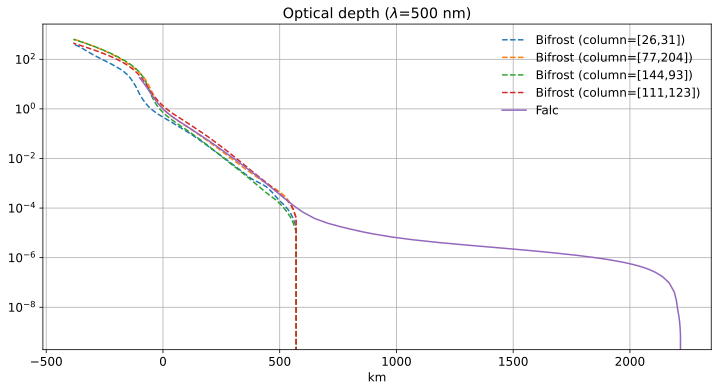

In [157]:
# choosing 5 random columns from the bifrost model
#np.random.seed(100)
five_cols = np.random.randint(0,temperature.shape[1], (4,2))

plt.figure(figsize=[12,6])
for x,y in five_cols:
    plt.plot(height.to("km"), opt_depth[:,x,y,:], "--", label="Bifrost (column=[%i,%i])" % (x,y))
plt.plot(height_falc.to("km"), opt_depth_falc, label="Falc")
plt.legend()
plt.grid()
plt.title(r"Optical depth ($\lambda$=500 nm)")
plt.yscale("log")
plt.show()

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
* In the 3D case $h(\tau_{500}=1)$, the height where $\tau_{500} = 1$ (when the atmosphere becomes transparent for 500 nm), varies along the horizontal dimensions. Using your already calculated $\tau_{500}$, calculate and plot $h(\tau_{500}=1)$ by interpolating, for each column, the curve of $\tau_{500}$ vs height. Show $h(\tau_{500}=1)$ as a 2D plot (image) and as a 3D surface plot (see below for hints on how to make this plot). Which column is formed deeper, and which one is formed higher up in the atmosphere?
    
Answer:
</div>

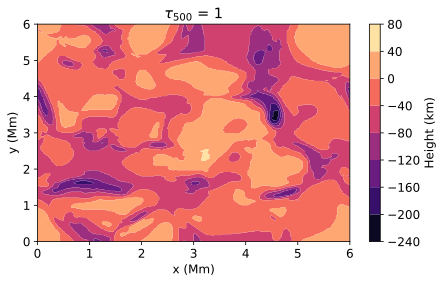

In [154]:
tau_equal_1 = np.argmin(abs(opt_depth-1),axis=0)[:,:,0]

xdim = np.linspace(0, 6, temperature.shape[1])
ydim = np.linspace(0, 6, temperature.shape[2])
plt.contourf(xdim, ydim, height[tau_equal_1].to("km"), cmap="magma")
plt.colorbar(label="Height (km)")
plt.title(r"$\tau_{500}$ = 1")
plt.xlabel("x (Mm)")
plt.ylabel("y (Mm)")
plt.show()


from mpl_toolkits.mplot3d import Axes3D

# x and y grids, from 0 to 6 Mm (box size), 256 points
X, Y = np.mgrid[0:6:256j, 0:6:256j]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plt.title(r"$\tau_{500}$ = 1")
# tau1_height must be a 2D array (256, 256) with the
# heights where tau = 1 in km
ax.plot_surface(X, Y, height[tau_equal_1].to("km"), cmap='magma', rcount=100, ccount=100)
ax.axis((6.3, -0.3, -0.3, 6.3));
ax.set_xlabel("y (Mm)")
ax.set_ylabel("x (Mm)")
ax.set_zlabel("z (km)")
plt.show()

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

* Discuss the spatial variations of the $h(\tau_{500}=1)$ you found. Do these relate to spatial structures in the simulation? Which quantity/quantities from the simulation better reflect the map of $h(\tau_{500}=1)$? (Hint: have a look at vertical cuts from the simulation quantities.)

Answer:
</div>

There is clearly a difference in where $h(\tau = 1)$ is defined for all the 256 $\times$ 256 columns as we observe from the plots above. We notice from the contour plot that $h(\tau = 1)$ can be found in both positive and negative heights with respect height given from the Bifrost model. Må skrive meeeer

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

* The height scale of the simulation is built such that $h=0$ m when $\tau_{500}=1$. Is the average value of your $h(\tau_{500}=1)$ close to zero? Discuss possible effects that may lead to a mismatch.

Answer:
</div>

In [158]:
mean_height_tau500 = np.mean(height[tau_eq_1[:,:,0]])
mean_height_tau500.to("km")

<Quantity -32.2455406 km>

### Exercise 2: Continuous Intensity at Different Angles

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
* Using $\tau_{500}$ you computed in the previous exercise, now compute and plot the disk-centre continuous intensity at 500 nm from the 3D model. The result should look like the solar granulation.

Answer:
</div>

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
* Compute the continuous intensity at 500 nm from the simulation at two viewing angles: $\mu$=0.4 and 0.2 (inclination angles of about 66° and 78°). Plot both intensity maps with identical physical sizes in the x and y axes.

Answer:
</div>

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
* In 3D space a rotation can be along two angles. Here, $\mu$ represents a rotation along the polar angle, but one can also do a rotation around an azimuthal angle. How would you rotate the simulation cubes by an azimuthal angle? You don't need to actually rotate the cubes, just explain how you would do it. (Think multiples of 90° rotations, and it becomes much easier.)

Answer:
</div>

### Exercise 3: The Na I D lines in 3D

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
* Compute the Na I D$_1$ line profiles from the 3D model for $\mu = 1$. You will need to modify the code you used in Project 5, both to add physics and to avoid filling up the memory of your computer (see hints in 1.3.2). Compute the spatially-averaged line profile, and plot it against a selection of line profiles from different xy points of the simulation (e.g. every 10th point in the y and x directions), so you can see the spatial variations between line profiles).
    
Answer:
</div>

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
* After you compute the intensities in the point above, you should obtain an array whose shape is `(nwave, nx, ny)`. Plot a spectrogram along one row or column of the simulation (e.g. `intensity_3d[:, 0]`), where the x axis is wavelength and the y axis is physical distance in Mm. You should see the meandering shifts of the line core, caused by Doppler motions. Exploring spectrograms from different slices, try to find a simulation column for which the line core peak is stronger (or comparable) than the intensity in the far wings. Compare with a different location where the wings are much stronger than the line core. Plot the two spectra and, based on your radiative transfer knowledge, explain the reason why they look so different. (Hint: look at the two source functions.)
    
Answer:
</div>

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

* For stars other than the Sun, we can only observe $F^+_\lambda$, the spatially-averaged flux profile, not the intensity at different angles and positions. Compute and plot the spatially-averaged Na I D$_1$ flux profile from the 3D model. You will need to calculate intensities for several angles and add them together using the flux integration techniques discussed in Project 5. Use 3 polar angles (same as in Project 5) and 4 azimuthal angles. To compute the intensity in 3D for inclined rays, the procedure is mostly identical to the $\mu=1$ case, but in addition to tilting the simulation's cubes, you will have to project the $v_x$, $v_y$, and $v_z$ components of velocity to obtain the line-of-sight velocity. **Note:**  *this computation will probably take more than one hour in modern machines. Make sure you have done everything correctly to this point to avoid long re-runs.*
    
Answer:
</div>